Episodes can be grouped by season,arc,saga,superSaga

In [22]:
from IMDBScraper import getSeriesInfo,getSeriesInfobySelenium
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import date
import numpy as np
import textwrap
df=getSeriesInfo("5753856")
for i,row in df.iterrows():
    df.loc[i,"orderNo"]=i+1
df["orderNo"]=df["orderNo"].astype("int")

In [18]:
texts=[]
plots=[]
groupingCheckList=[]

def getBorderCollisionList(obj):
    topBorder = ("top",ax.spines['top'].get_window_extent())
    rightBorder = ("right",ax.spines['right'].get_window_extent())
    bottomBorder = ("bottom",ax.spines['bottom'].get_window_extent())
    leftBorder = ("left",ax.spines['left'].get_window_extent())
    
    bordersList=[topBorder,rightBorder,bottomBorder,leftBorder]
    collisions=[]
    for (name,border) in bordersList:
        if obj.get_window_extent().overlaps(border): collisions.append((name,border))
    return collisions

def addTracker(obj, obj_tpye):
    global texts, plots
    if obj_tpye.endswith("text") or obj_tpye.endswith("Text") or obj_tpye.endswith("label") or obj_tpye.endswith("Label"):
        texts.append(obj)
    if obj_tpye.endswith("line") or obj_tpye.endswith("rectangle") or obj_tpye.endswith("plot"):
        plots.append(obj)
    
def checkForGroups(df):
    global groupingCheckList
    seasonOn=False
    arcOn=False
    sagaOn=False
    superSagaOn=False
    
    if 'season' in df.columns:
        seasonOn=True
    if 'arc' in df.columns:
        arcOn=True
    if 'saga' in df.columns:
        sagaOn=True
    if 'superSaga' in df.columns:
        superSagaOn=True
    
    groupingCheckList=[seasonOn,arcOn,sagaOn,superSagaOn]
    return groupingCheckList


    #TO DO
    #If order is not anticipated, move.
#     tempList=[superSagaOn,sagaOn,arcOn,seasonOn]    
#     for i,check in enumerate([superSagaOn,sagaOn,arcOn,seasonOn]):
#         if(check) and (i!=len(tempList)-1 and not tempList[i+1]):
#             print(i,check)


def setAxesLimits(df):
    #set timeline limits and rating limits
    global episodesRangeStart,episodesRangeEnd,ratingsStart,ratingsEnd,firstEpisode,lastEpisode,lowestRating,highestRating

    firstEpisode=df.loc[0,"orderNo"]
    lastEpisode=df.loc[0,"orderNo"]

    lowestRating=df.loc[0,"episodeRating"]
    highestRating=df.loc[0,"episodeRating"]

    for i,row in df.iterrows():
        if row["orderNo"]>lastEpisode:
            lastEpisode=row["orderNo"]
        if row["orderNo"]<firstEpisode:
            firstEpisode=row["orderNo"]

        if row["episodeRating"]>highestRating:
            highestRating=row["episodeRating"]
        if row["episodeRating"]<lowestRating:
            lowestRating=row["episodeRating"]

    episodesRangeStart=firstEpisode-1
    episodesRangeEnd=lastEpisode+1

    ratingsStart=int(lowestRating)
    if highestRating == 10:highestRating=9
    ratingsEnd=int(highestRating)+1


def setAxes(ax,df):
    def setYAxes(ax,df):
        # Set labels for the axes
        ax.set_ylabel('Rating')
        
        # Set the desired X-axis limits for a longer timeline
        ax.set_ylim(ratingsStart,ratingsEnd)
        # Decide number of ticks on the y-axis
        if (ratingsEnd-ratingsStart)<=1:
            majorTicksIncrement=0.5
            mainorTicksIncrement=0.25
        elif (ratingsEnd-ratingsStart)<=2:
            majorTicksIncrement=1
            minorTicksIncrement=0.25
        else:
            majorTicksIncrement=1
            minorTicksIncrement=0.5
        # Create the positions and labels for major ticks
        majorTicks = []
        current_value = ratingsStart
        while current_value <= ratingsEnd:
            majorTicks.append(current_value)
            current_value += majorTicksIncrement
        # Set the positions and labels of major ticks
        ax.set_yticks(majorTicks)
        ax.set_yticklabels(majorTicks)
        # Create the positions and labels for minor ticks
        minorTicks = []
        current_value = ratingsStart
        while current_value <= ratingsEnd:
            minorTicks.append(current_value)
            current_value += minorTicksIncrement

        # Set the positions and labels of minor ticks
        ax.set_yticks(minorTicks, minor=True)
        ax.set_yticklabels(minorTicks, minor=True, fontsize=8)
        
        # Add minor ticks in the Y-axis at minorLocator amount between each
        ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
        # Set the Y-axis limits based on the minimum and maximum ratings
        ax.set_ylim(ratingsStart, ratingsEnd)
        
        
    def setXAxes(ax,df):
        # Set the desired X-axis limits for a longer timeline
        ax.set_xlim(episodesRangeStart, episodesRangeEnd)

        # Set the positions of ticks
        episodeTicks=[order for order in df["orderNo"]]
        ax.set_xticks(episodeTicks)
        ax.set_xticklabels(df["episode"],fontsize=12)
        # Set labels for the axes
        #ax.set_xlabel('Episode',labelpad=x_Label_Padding_Amount(ax,df))

    setXAxes(ax,df)
    setYAxes(ax,df)
    ax.spines["top"].set_zorder(4)
    ax.spines["bottom"].set_zorder(4)

def setGrid(ax):
    # Show the plot
    ax.grid(color='gray', linestyle='--', linewidth=1)  # Change the grid color, style, and linewidth
    # Enable minor grids
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

def addDate(ax):
    today = date.today()
    dateLabel=ax.text(episodesRangeEnd,
            ratingsStart,
            str(today),
            fontsize=10,
            ha='right',
            va='bottom',
            zorder=6,
            color='black')
    addTracker(dateLabel,"dateText")

def addTitle(plt,ax,df):
    title=df.loc[0,"title"]
    rating=df["showRating"][0]
    plt.title(f"{title} (IMDB={rating})",fontsize=16, pad=30)
    #ax.set_title(title, fontsize=16)
    
    
    
groupingCheckList=checkForGroups(df)

In [66]:
def findSelectedGroupList(df,metaGroupName):
    selectedGroupNoList=list(set(df[metaGroupName]))
    return selectedGroupNoList


def findselectedGroupIntervals(df,metaGroupName):    
    selectedGroupNoList=findSelectedGroupList(df,metaGroupName)
    selectedGroupIntervals={}
    for groupName in selectedGroupNoList:
        start=df[df[metaGroupName]==groupName].reset_index(drop=True)["orderNo"][0]
        end=df[df[metaGroupName]==groupName].reset_index(drop=True)["orderNo"][0]
        for order in df[df[metaGroupName]==groupName]["orderNo"]:
            if start>order: start=order
            if end<order: end=order
        selectedGroupIntervals[groupName]=[start,end]
    return selectedGroupIntervals


def addOverallMean(df,ax):
    start_x_value=firstEpisode
    end_x_value=lastEpisode

    overallMean=df["episodeRating"].mean()
    
    #Plot means
    ax.plot([start_x_value, end_x_value],
            [overallMean, overallMean],
            color='black',
            alpha=0.6,
            zorder=5,
            linewidth=2)
    
    # Set overallMeanLabels
    overallMeanLabel=ax.text(end_x_value-0.02,
                             overallMean+0.01,
                             str(f"Overall Mean"),
                             fontsize=10,
                             ha='right',
                             va='bottom',
                             zorder=6,
                             color='black')
    addTracker(overallMeanLabel, "overallMeanLabel")

def addDataPoints(df,ax):
    for index, row in df.iterrows():

        # Define the width of each rectangle
        rectangle_width = 0.1
        rectangle_height = 0.02
        
        #set Positions for rectangles
        x = float(row['orderNo'])-(rectangle_width/2)
        y = row['episodeRating']-(rectangle_height/2)
        

        
        # Create a rectangle patch and add it to the plot
        rectangle = Rectangle((x,y), #Place the left bottom corner
                              rectangle_width,
                              rectangle_height,
                              edgecolor='black',
                              facecolor='blue',
                              linewidth=1,
                              zorder=5)
        addTracker(rectangle, "rectangle")
        # Add the rectangle to the plot
        ax.add_patch(rectangle)

def addPlotLine(df,ax):
    for index, row in df.iterrows():
        if index==0:
            leftPointX=row["orderNo"]
            leftPointY=row['episodeRating']

        rightPointX=row["orderNo"]
        rightPointY=row['episodeRating']

        #plotline
        plotLine=ax.plot([leftPointX, rightPointX],
                [leftPointY, rightPointY],
                color="darkred",
                alpha=0.5,
                zorder=5)
        addTracker(plotLine, "plotLine")
        leftPointX=rightPointX
        leftPointY=rightPointY

        # Plot a little circle (scatter point) at a specific coordinate
        #ax.scatter(row['First aired'], row['IMDB Rating'], marker='o', color="darkred", s=20, alpha=0.5, zorder=4)  # s parameter controls the size of the circle

def addMinandMaxData(df,ax,groupingCheckList=groupingCheckList):
    
    def addMaxLabel(maxEpisodeOrder,maxEpisodeRating,maxTitle,level,group):
        maxLabel=ax.text(maxEpisodeOrder+0.04,
                         maxEpisodeRating+0.015,
                         maxTitle,
                         ha="left",
                         va="bottom",
                         zorder=valuePicker(level,"addMinandMaxData-maxNameLabelz",group))
        if len(getBorderCollisionList(maxLabel))>0:
            maxLabel.set_ha("right")
            maxLabel.set_position((maxEpisodeOrder-0.04,maxEpisodeRating+0.015))
        addTracker(maxLabel, "maxLabel")
        
        
    def addMinandMaxData_insider(df,ax,groupIntervals,metaGroupName,level):
        for group in selectedGroupIntervals:
            groupdf=df[df[metaGroupName]==group].reset_index(drop=True)

            idxMin=groupdf["episodeRating"].idxmin()
            minEpisodeOrder=groupdf.loc[idxMin,"orderNo"]
            minEpisodeRating=groupdf.loc[idxMin,"episodeRating"]
            minTitle=groupdf.loc[idxMin,"episodeTitle"]
            if group==99: fillAmount=20
            else: fillAmount=20
            minTitle=textwrap.fill(minTitle,fillAmount)
            minLabel=ax.text(minEpisodeOrder+0.04,
                            minEpisodeRating-0.015,
                            minTitle,
                            ha="left",
                            va="top",
                            zorder=valuePicker(level,"addMinandMaxData-minNameLabelz",group))
            addTracker(minLabel, "minLabel")

            idxMax=groupdf["episodeRating"].idxmax()
            maxEpisodeOrder=groupdf.loc[idxMax,"orderNo"]
            maxEpisodeRating=groupdf.loc[idxMax,"episodeRating"]
            maxTitle=groupdf.loc[idxMax,"episodeTitle"]
            if group==99: fillAmount=11
            else: fillAmount=20
            maxTitle=textwrap.fill(maxTitle,fillAmount)
            addMaxLabel(maxEpisodeOrder,maxEpisodeRating,maxTitle,level,group)            
            
            
    def addMinandMaxDataForAll_insider(df,ax):
        idxMin=df["episodeRating"].idxmin()
        minEpisodeOrder=df.loc[idxMin,"orderNo"]
        minEpisodeRating=df.loc[idxMin,"episodeRating"]
        minTitle=df.loc[idxMin,"episodeTitle"]
        minLabel=ax.text(minEpisodeOrder+0.04,
                        minEpisodeRating-0.015,
                        minTitle,
                        ha="left",
                        va="top",
                        zorder=valuePicker(0,"addMinandMaxData-minNameLabelz",None))
        addTracker(minLabel, "minLabel")


        idxMax=df["episodeRating"].idxmax()
        maxEpisodeOrder=df.loc[idxMax,"orderNo"]
        maxEpisodeRating=df.loc[idxMax,"episodeRating"]
        maxTitle=df.loc[idxMax,"episodeTitle"]
        addMaxLabel(maxEpisodeOrder,maxEpisodeRating,maxTitle,0,None)
        
    if any(groupingCheckList):
        for i,check in enumerate(groupingCheckList):
            if check:
                [level,metaGroupName]=groupDetails(i)
                selectedGroupIntervals=findselectedGroupIntervals(df,metaGroupName)
                addMinandMaxData_insider(df,ax,selectedGroupIntervals,metaGroupName,level)
    else:
        addMinandMaxDataForAll_insider(df,ax)

        

setAxesLimits(df)
print(ratingsStart,ratingsEnd,episodesRangeStart,episodesRangeEnd,firstEpisode,lastEpisode)
checkForGroups(df)

def x_Label_Padding_Amount(ax,df):
    padAmount=20
    padIncreaser=20
    for level in onlineGroupLabelsToXAxis:
        if level: padAmount+=padIncreaser
    return padAmount

def addGroupBackgrounds(df,ax,groupingCheckList=groupingCheckList):
    def addGroupBackgrounds_insider(df,ax,groupIntervals,metaGroupName,level):
        for group in selectedGroupIntervals:
            start_x_value=selectedGroupIntervals[group][0]
            end_x_value=selectedGroupIntervals[group][1]
            
            # Set the background color of the shaded region
            ax.axvspan(start_x_value,
                       end_x_value,
                       color=valuePicker(level,"addGroupBackgrounds-bg",group),
                       alpha=valuePicker(level,"addGroupBackgrounds-alpha",group),
                       zorder=valuePicker(level,"addGroupBackgrounds-z",group))
    
    for i,check in enumerate(groupingCheckList):
        if check:
            [level,metaGroupName]=groupDetails(i)
            selectedGroupIntervals=findselectedGroupIntervals(df,metaGroupName)
            addGroupBackgrounds_insider(df,ax,selectedGroupIntervals,metaGroupName,level)
    
def groupDetails(i):
    metaGroupName=""
    level=0
    if type(i)==int or (type(i)==str and i.isdigit()):
        i=int(i)
        if i==0:metaGroupName="season"
        if i==1:metaGroupName="arc"
        if i==2:metaGroupName="saga"
        if i==3:metaGroupName="superSaga"
        return [i,metaGroupName]
    else:
        if i=="season":level==0
        if i=="arc":level==1
        if i=="saga":level==2
        if i=="superSaga":level==3
        return [level,i]
        
        
def addGroupLabelsToXAxis(df,ax,groupingCheckList=groupingCheckList):
    def addGroupLabelsToXAxis_insider(df,ax,groupIntervals,metaGroupName,level):
        for group in selectedGroupIntervals:
            start_x_value=selectedGroupIntervals[group][0]
            end_x_value=selectedGroupIntervals[group][1]
            
            # Set groupLabels
            groupLabel=ax.text(start_x_value+(end_x_value-start_x_value)/2,
                               ratingsStart-valuePicker(level,"addGroupLabelsToXAxis-padding",group),
                               str(valuePicker(level,"addGroupLabelsToXAxis-groupLabel",group)),
                               fontsize=12,
                               ha='center',
                               va='bottom',
                               zorder=6,
                               color="red",
                               alpha=1,
                               fontweight=None)
            addTracker(groupLabel, "groupLabel")
    
    for i,check in enumerate(groupingCheckList):
        if check:
            [level,metaGroupName]=groupDetails(i)
            selectedGroupIntervals=findselectedGroupIntervals(df,metaGroupName)
            addGroupLabelsToXAxis_insider(df,ax,selectedGroupIntervals,metaGroupName,level)
            

            
def addGroupMeansToGraph(df,ax,groupingCheckList):
    def addGroupMeansToGraph_insider(df,ax,groupIntervals,metaGroupName,level):
        for group in selectedGroupIntervals:
            start_x_value=selectedGroupIntervals[group][0]
            end_x_value=selectedGroupIntervals[group][1]
            groupMean=df[df[metaGroupName]==group]["episodeRating"].mean()
            
            #Plot means
            ax.plot([start_x_value, end_x_value],
                    [groupMean, groupMean],
                    color=valuePicker(level,"addGroupMeansToGraph-line",group),
                    alpha=valuePicker(level,"addGroupMeansToGraph-linealpha",group),
                    zorder=valuePicker(level,"addGroupMeansToGraph-linez",group))
            # Set seasonMeanLabels
            groupMeanLabel=ax.text(end_x_value+0.1,
                                   groupMean-0.01,
                                    str(valuePicker(level,"addGroupMeansToGraph-groupMeanLabel",group)),
                                   fontsize=10,
                                   ha='center',
                                   va='top',
                                   zorder=valuePicker(level,"addGroupMeansToGraph-groupMeanLabelz",group),
                                   color=valuePicker(level,"addGroupMeansToGraph-groupMeanLabelColor",group))
            addTracker(groupMeanLabel, "groupMeanLabel")
    
    for i,check in enumerate(groupingCheckList):
        if check:
            [level,metaGroupName]=groupDetails(i)
            selectedGroupIntervals=findselectedGroupIntervals(df,metaGroupName)
            addGroupMeansToGraph_insider(df,ax,selectedGroupIntervals,metaGroupName,level)
            

def valuePicker(level,context,group):
    if context=="addGroupBackgrounds-bg":
        if level==0:   return "#F0F0FA"
        elif level==1: return "green"
        elif level==2: return "blue"
        elif level==3: return "yellow"
    elif context=="addGroupBackgrounds-alpha":
        if level==0:   return 0.5
        elif level==1: return 0.5
        elif level==2: return 0.5
        elif level==3: return 0.5
    elif context=="addGroupBackgrounds-z":
        if level==0:   return 4
        elif level==1: return 3
        elif level==2: return 2
        elif level==3: return 1
        
    elif context=="addGroupMeansToGraph-line":
        if level==0:   return "purple"
        elif level==1: return "darkgreen"
        elif level==2: return "darkblue"
        elif level==3: return "darkyellow"
    elif context=="addGroupMeansToGraph-linealpha":
        if level==0:   return 0.5
        elif level==1: return 0.5
        elif level==2: return 0.5
        elif level==3: return 0.5
    elif context=="addGroupMeansToGraph-linez":
        if level==0:   return 4
        elif level==1: return 3
        elif level==2: return 2
        elif level==3: return 1
    elif context=="addGroupMeansToGraph-groupMeanLabel":
        if level==0:   return str(f"S{group} Mean")
        elif level==1: return str(f"{group} Mean")
        elif level==2: return str(f"{group} Mean")
        elif level==3: return str(f"{group} Mean")
    elif context=="addGroupMeansToGraph-groupMeanLabelColor":
        if level==0:   return "purple"
        elif level==1: return "darkgreen"
        elif level==2: return "darkblue"
        elif level==3: return "darkyellow"
    elif context=="addGroupMeansToGraph-groupMeanLabelz":
        if level==0:   return 4
        elif level==1: return 3
        elif level==2: return 2
        elif level==3: return 1
    elif context=="addGroupLabelsToXAxis-padding":
        padding=0.25
        if level==0:   return padding*(level+1)
        elif level==1: return padding*(level+1)
        elif level==2: return padding*(level+1)
        elif level==3: return padding*(level+1)
    elif context=="addGroupLabelsToXAxis-groupLabel":
        if level==0:   return str(f"Season {group}")
        elif level==1: return str(f"{group}")
        elif level==2: return str(f"{group}")
        elif level==3: return str(f"{group}")
    elif context=="addMinandMaxData-minNameLabelz":
        if level==0:   return 4
        elif level==1: return 3
        elif level==2: return 2
        elif level==3: return 1
    elif context=="addMinandMaxData-maxNameLabelz":
        if level==0:   return 4
        elif level==1: return 3
        elif level==2: return 2
        elif level==3: return 1
    else:
        print("Context is unkown",context)

8 10 0 27 1 26


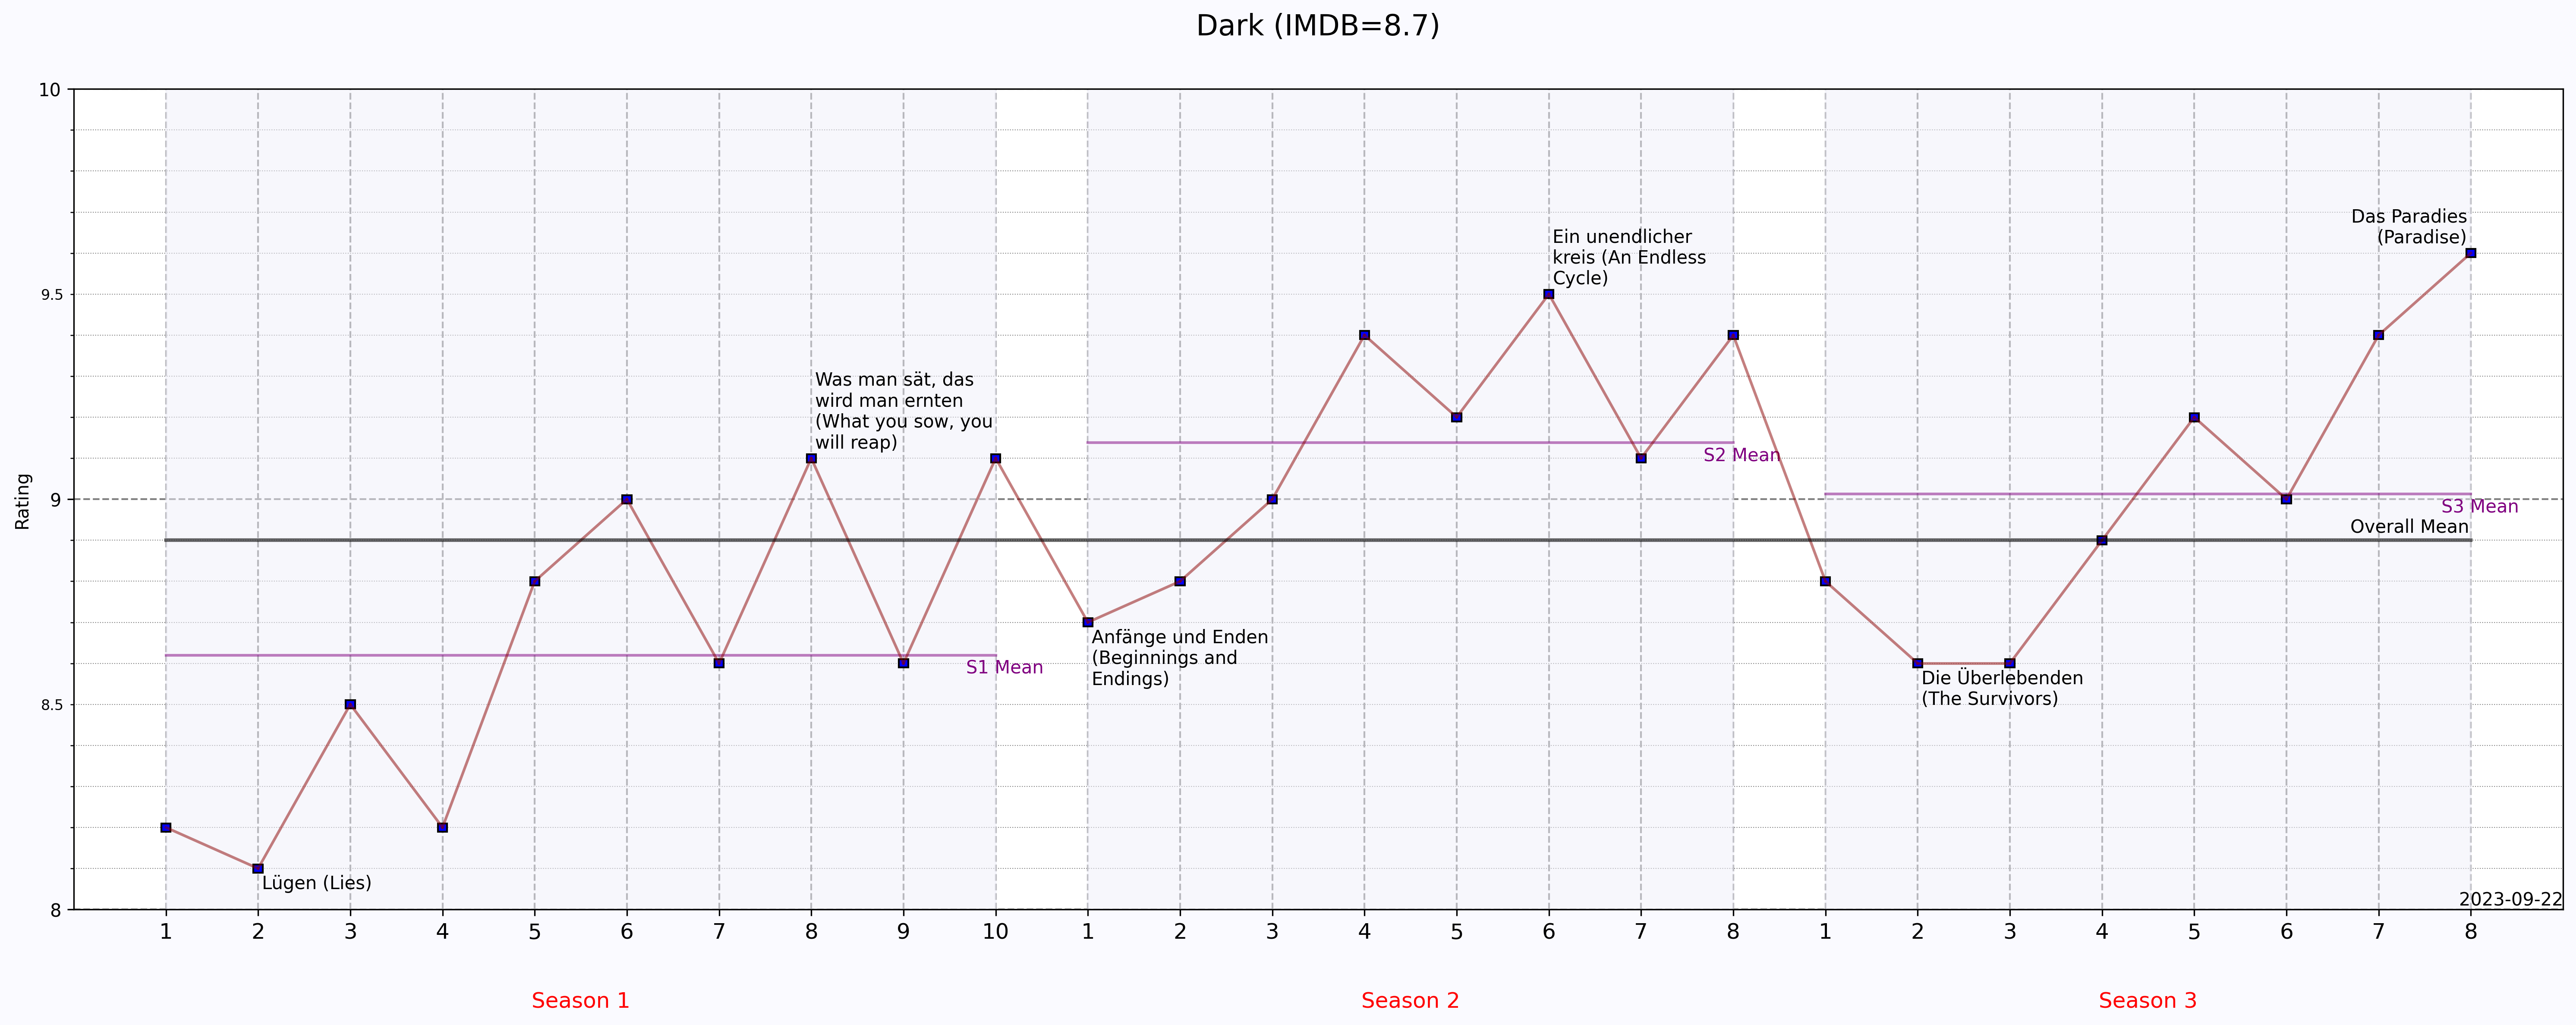

In [67]:
#Create a date based figure

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 8),dpi=300)

#Add Rectangles
addDataPoints(df,ax)

#Add plot line
addPlotLine(df,ax)
  
# Add group backgrounds addGroupBackgrounds(df,ax,groupingCheckList=groupingCheckList)
onlineGroupBackgrounds=[True,False,False,False]
addGroupBackgrounds(df,ax,onlineGroupBackgrounds) #[seasonOn,arcOn,sagaOn,superSagaOn]

# Add group means to graph: addGroupLabels(df,ax,groupingCheckList=groupingCheckList)
onlineGroupMeansOnGraph=[True,False,False,False]
addGroupMeansToGraph(df,ax,onlineGroupMeansOnGraph) #[seasonOn,arcOn,sagaOn,superSagaOn]

# Add group labels to X-Axis addGroupLabels(df,ax,groupingCheckList=groupingCheckList)
onlineGroupLabelsToXAxis=[True,False,False,False]
addGroupLabelsToXAxis(df,ax,onlineGroupLabelsToXAxis) #[seasonOn,arcOn,sagaOn,superSagaOn]

# Add min and max points addMinandMaxData(df,ax,groupingCheckList=groupingCheckList)
onlineMinandMaxGroups=[True,False,False,False]
addMinandMaxData(df,ax, onlineMinandMaxGroups)

#TO DO
# Add group labels background
# Add group labels mean info

# Add overall means:
addOverallMean(df,ax)

setAxes(ax,df)
setGrid(ax)

# Set Background color
fig.set_facecolor('#FAFAFF')

# Add todays date.
addDate(ax)

# Add Title
addTitle(plt,ax,df)
# Show the plot
plt.tight_layout()

In [45]:
df.loc[25,"episodeTitle"]="Das Paradies (Paradise)"

In [23]:
df

,title,episodeTitle,season,episode,episodeRating,episodeDate,episodeID,posterURL,showRating,episodeDateTimestamp,episodeDateString,orderNo
0,Dark,Geheimnisse,1,1,8.2,2017-12-01,6305578,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",1
1,Dark,Lügen,1,2,8.1,2017-12-01,7305776,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",2
2,Dark,Gestern und heute,1,3,8.5,2017-12-01,7305820,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",3
3,Dark,Doppelleben,1,4,8.2,2017-12-01,7305818,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",4
4,Dark,Wahrheiten,1,5,8.8,2017-12-01,7313308,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",5
5,Dark,Sic Mundus Creatus Est,1,6,9.0,2017-12-01,7313312,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",6
6,Dark,Kreuzwege,1,7,8.6,2017-12-01,7305824,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",7
7,Dark,"Was man sät, das wird man ernten",1,8,9.1,2017-12-01,7313316,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",8
8,Dark,Alles ist jetzt,1,9,8.6,2017-12-01,7313320,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",9
9,Dark,Alpha und Omega,1,10,9.1,2017-12-01,7313322,https://m.media-amazon.com/images/M/MV5BOTk2Nz...,8.7,1512086400,"Fri, Dec 1, 2017",10


In [63]:
textwrap.fill("Was man sät, das wird man ernten	",20)

'Was man sät, das\nwird man ernten'